In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})
# import matplotlib.pylab as pl
from matplotlib import cm

In [3]:
# Import data from methodology_rates_iv
all = pd.concat([pd.read_hdf(os.path.join("..", "data", "spx_iv_db_1.h5")), 
                 pd.read_hdf(os.path.join("..", "data", "spx_iv_db_2.h5"))])

df = all[(all["EXP"]=="2017-12-15") & (all["BUS_DAYS"] < 126)].reset_index(drop=True).dropna()

df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK
0,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196
1,2017-07-03,2017-12-15,2425,P,77.7,78.600,79.50,25,13822,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1168,0.1182,0.1196
2,2017-07-03,2017-12-15,2450,P,87.8,88.750,89.70,0,5926,2429.01,20.99,1,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1114,0.1128,0.1143
3,2017-07-03,2017-12-15,2450,C,59.8,60.700,61.60,7,19022,2429.01,20.99,1,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1115,0.1129,0.1143
4,2017-07-03,2017-12-15,2400,P,68.9,69.800,70.70,501,32564,2429.01,29.01,2,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1223,0.1237,0.1251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19944,2017-12-14,2017-12-15,2540,P,0.1,0.200,0.30,20,31619,2652.06,112.06,44,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.2825,0.3077,0.3253
19948,2017-12-14,2017-12-15,2535,P,0.1,0.200,0.30,73,15733,2652.06,117.06,46,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.2936,0.3197,0.3378
19952,2017-12-14,2017-12-15,2530,P,0.1,0.200,0.30,16,15516,2652.06,122.06,48,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3048,0.3316,0.3502
19957,2017-12-14,2017-12-15,2525,P,0.1,0.200,0.30,1147,67725,2652.06,127.06,50,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3159,0.3435,0.3627


In [4]:
# Add ATM_VOLS

ATM_vols = df[df["RANK"]==0]
df = pd.merge(df, ATM_vols[["TS", "TYPE", "IV_BID", "IV_ASK"]], left_on=["TS", "TYPE"], right_on=["TS", "TYPE"], 
              suffixes=(None, "_ATM"), how="left")

In [5]:
# Add useful columns
df["MONEYNESS"] = df["UNDERLYING_PRICE"] - df["STRIKE"]

df["MONEYNESS_F"] = df["STRIKE"]/df["F_T"]
df["LOG_MONEYNESS_F"] = np.log(df["MONEYNESS_F"])
df["LOG_MONEYNESS_F_STANDARD_TIME"] = df["LOG_MONEYNESS_F"] / np.sqrt(df["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

df["IV_BID_DIFF"] = df["IV_BID"] - df["IV_BID_ATM"]
df["IV_ASK_DIFF"] = df["IV_ASK"] - df["IV_ASK_ATM"]

df["IV_BID_RATIO"] = df["IV_BID"]/df["IV_BID_ATM"]
df["IV_ASK_RATIO"] = df["IV_ASK"]/df["IV_ASK_ATM"]

In [6]:
def plot_IV_2D(df, xlabel, ylabel, interval=5, otm=True, option_type="C"):
    fig, ax = plt.subplots()
    
    dates = df["TS"].unique()[::interval]
    
    # This sets the gradient of the colors
    colors = cm.viridis(np.linspace(0,0.8,len(dates)))
    
    for i, date in enumerate(dates):
        to_plot = df[(df["TS"]==date)].sort_values(xlabel).copy()
        
        if otm:
            c_otm = (to_plot['TYPE']=='C') & (to_plot["STRIKE"] > to_plot["UNDERLYING_PRICE"])
            p_otm = (to_plot['TYPE']=='P') & (to_plot["STRIKE"] < to_plot["UNDERLYING_PRICE"])
            to_plot = to_plot[c_otm | p_otm]
        else:
            to_plot = to_plot[to_plot["TYPE"]==option_type]
            
        dte = to_plot["CAL_DAYS"].iloc[0]
        ax.plot(to_plot[xlabel], to_plot[ylabel], label="{} DTE".format(dte), color=colors[i])
        
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.set_title("{} vs {}".format(ylabel, xlabel), size=18)
    ax.legend()

# LOG-MONEYNESS

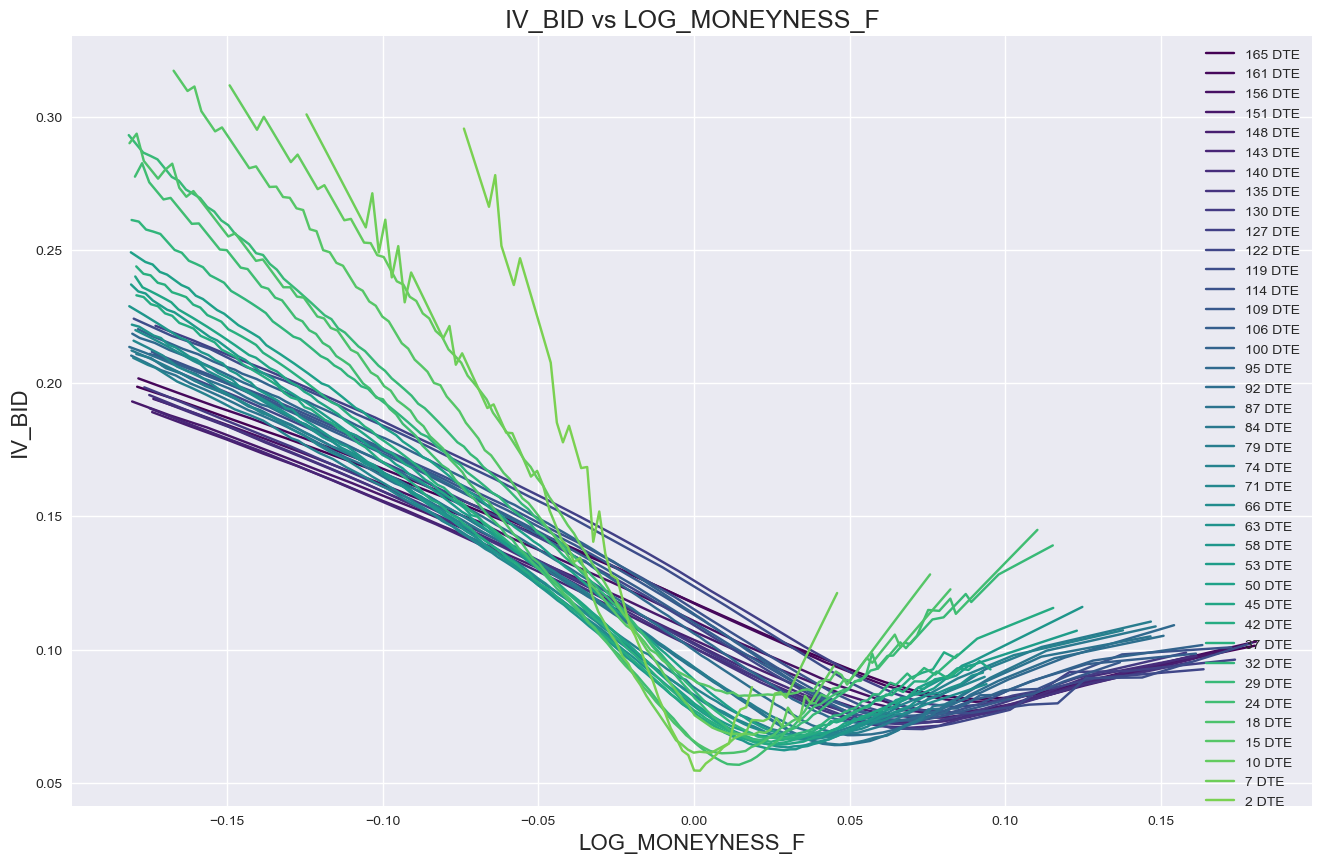

In [7]:
plot_IV_2D(df, "LOG_MONEYNESS_F", "IV_BID", interval=3)

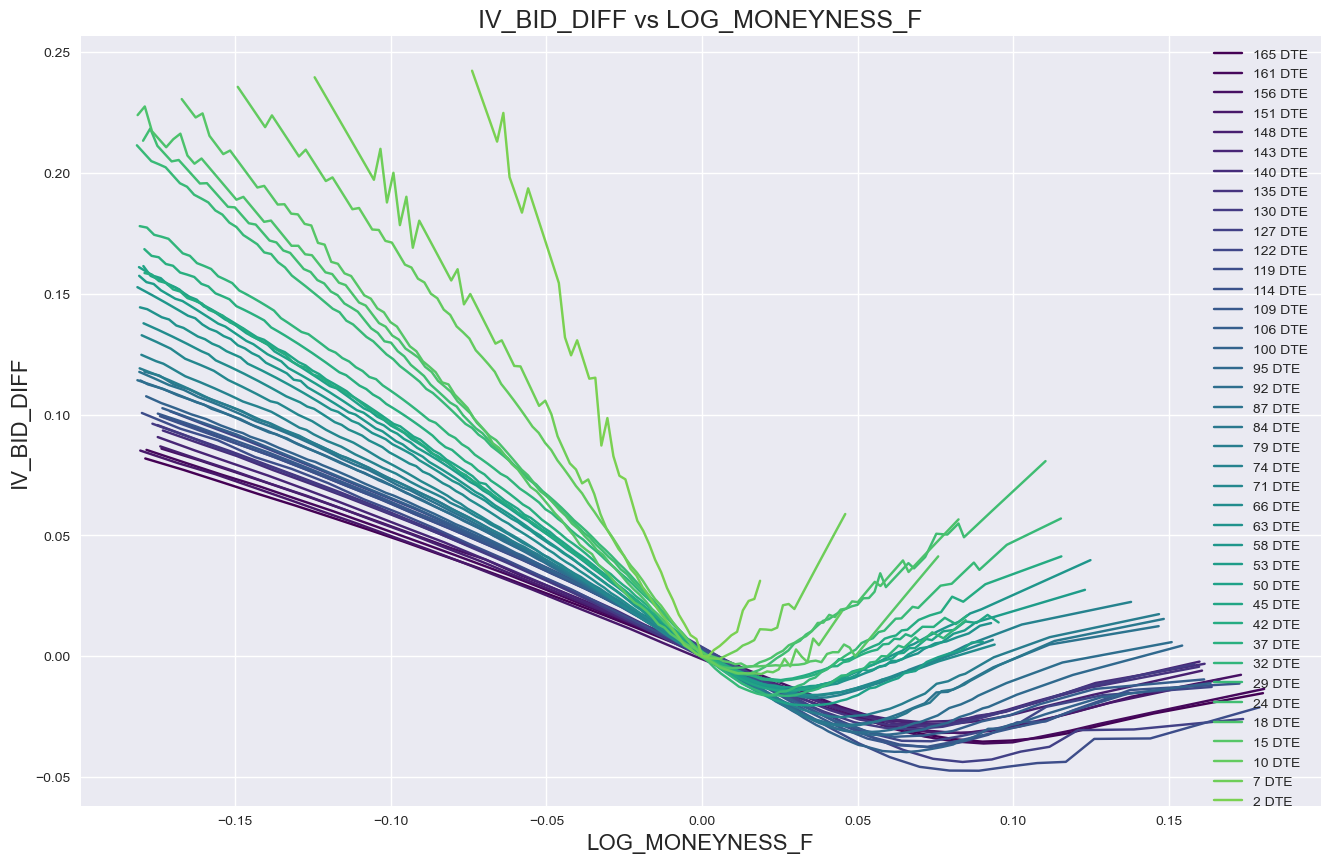

In [8]:
plot_IV_2D(df, "LOG_MONEYNESS_F", "IV_BID_DIFF", interval=3)

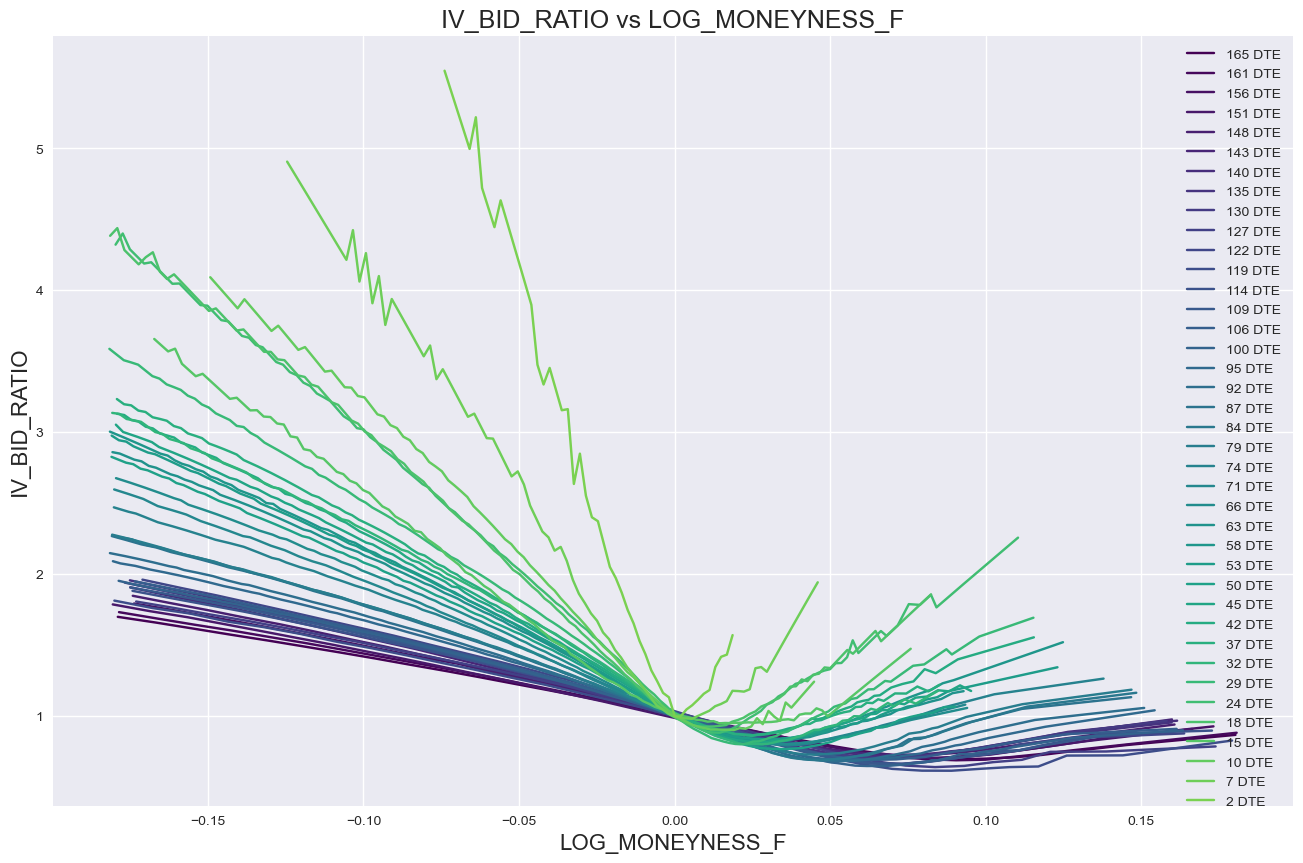

In [9]:
plot_IV_2D(df, "LOG_MONEYNESS_F", "IV_BID_RATIO", interval=3)

[Hyperbola Equation](https://www.desmos.com/calculator/phvqct3f4b):

$$\begin{aligned}
    y &= \sqrt{b^{2}\left(1+\frac{\left(x-c\right)^{2}}{a^{2}}\right)}+d(x-c) + e
\end{aligned}$$

Derive the Jacobian with respect to the parameter terms:

$$\begin{aligned}
    J(y) &= \begin{bmatrix}
        \frac{\partial y}{\partial a} & \frac{\partial y}{\partial b} & \frac{\partial y}{\partial c} &
        \frac{\partial y}{\partial d} & \frac{\partial y}{\partial e}
        \end{bmatrix} \\
    u &= b^{2}\left(1+\frac{\left(x-c\right)^{2}}{a^{2}}\right) \\
    \frac{\partial \sqrt{u}}{\partial \circ} &= \frac{\frac{\partial u}{\partial \circ}}{2\sqrt{u}}; \frac{\partial u}{\partial a} = \frac{-2 b^2 \left(x-c\right)^{2}}{a^{3}}; \frac{\partial u}{\partial c} = \frac{-2 b^2 \left(x-c\right)}{a^{2}} \\
    \frac{\partial y}{\partial a} &= -\frac{b^2 \left(x-c\right)^{2}}{a^{3} \sqrt{u}} \\
    \frac{\partial y}{\partial b} &= \sqrt{1+\frac{\left(x-c\right)^{2}}{a^{2}}} \\
    \frac{\partial y}{\partial c} &= -\frac{b^2 \left(x-c\right)}{a^{2} \sqrt{u}} - d \\
    \frac{\partial y}{\partial d} &= (x-c) \\
    \frac{\partial y}{\partial e} &= \mathbb{1}
\end{aligned}$$

Derive the lowest point and the global minimizer $x_*$ of the hyperbola:

$$\begin{aligned}
    y' &= \frac{b(x-c)}{a^2 \sqrt{1+\frac{(x-c)^2}{a^2}}} + d \\
    x_* &= (a^2 c d^2 + d\sqrt{a^4 b^2 - a^6 d^2} - b^2 c)/(a^2 d^2 - b^2) \\
    y_* &= y(x_*)
\end{aligned}$$

In [10]:
def hyperbola(x, a, b, c, d, e) -> float:
    """Tiltable hyperbola for scipy.optimize.curve_fit
    Asymptotes at 
    y=(-b/a+d)(x-c)+e
    y=( b/a+d)(x-c)+e"""
    return (b**2*(1+(x-c)**2/a**2))**0.5+d*(x-c)+e

def hyperbola_jac(x, a, b, c, d, e) -> np.ndarray:
    """Jacobian of the hyperbola with respect to each parameter"""
    ru = np.sqrt(b**2*(1+(x-c)**2/a**2))
    da = -(b**2 * (x-c)**2) / (a**3 * ru)
    db = np.sqrt(1+(x-c)**2/a**2)
    dc = -(b**2 * (x-c)) / (a**2 * ru) - d
    dd = x-c
    de = np.ones(len(x))
    return np.array([da, db, dc, dd, de]).T

def hyperbola_minimizer(a, b, c, d, e) -> float:
    """Returns the minimizer (x such that y is the minimum) of a hyperbola"""
    return ((a**2 * c * d**2 + d*(a**4 * b**2 - a**6 * d**2)**0.5 - b**2 * c)
            /(a**2 * d**2 - b**2))

def fit_hyp(df) -> np.ndarray:
    """Fits a hyperbola for a day's IV single curve"""
    curve = df.dropna()
    bounds = ((1e-4, 1e-4, 0, -2, -2), (1, 1, 1, 2, 2))
    popt, pcov = curve_fit(hyperbola, curve["LOG_MONEYNESS_F"], curve["IV_MID"]**2, 
                           jac=hyperbola_jac, bounds=bounds)
    return popt

otm_mask = (((df["TYPE"]=='C') & (df["STRIKE"]>df["UNDERLYING_PRICE"])) 
            | ((df["TYPE"]=='P') & (df["STRIKE"]<=df["UNDERLYING_PRICE"])))

otm  = df[otm_mask].copy().reset_index(drop=True)
to_fit = otm

fits = to_fit.groupby("TS").apply(fit_hyp)

fits = np.array([v for v in fits.values])
X = np.linspace(-0.2,0.2,100)
preds = [hyperbola(X, *i) for i in fits]

fit_df = pd.DataFrame(fits, index=to_fit["TS"].unique(), columns=['a', 'b', 'c', 'd', 'e'])
tss = to_fit["TS"].unique()

# Example Fit

<class 'matplotlib.axes._subplots.AxesSubplot'>


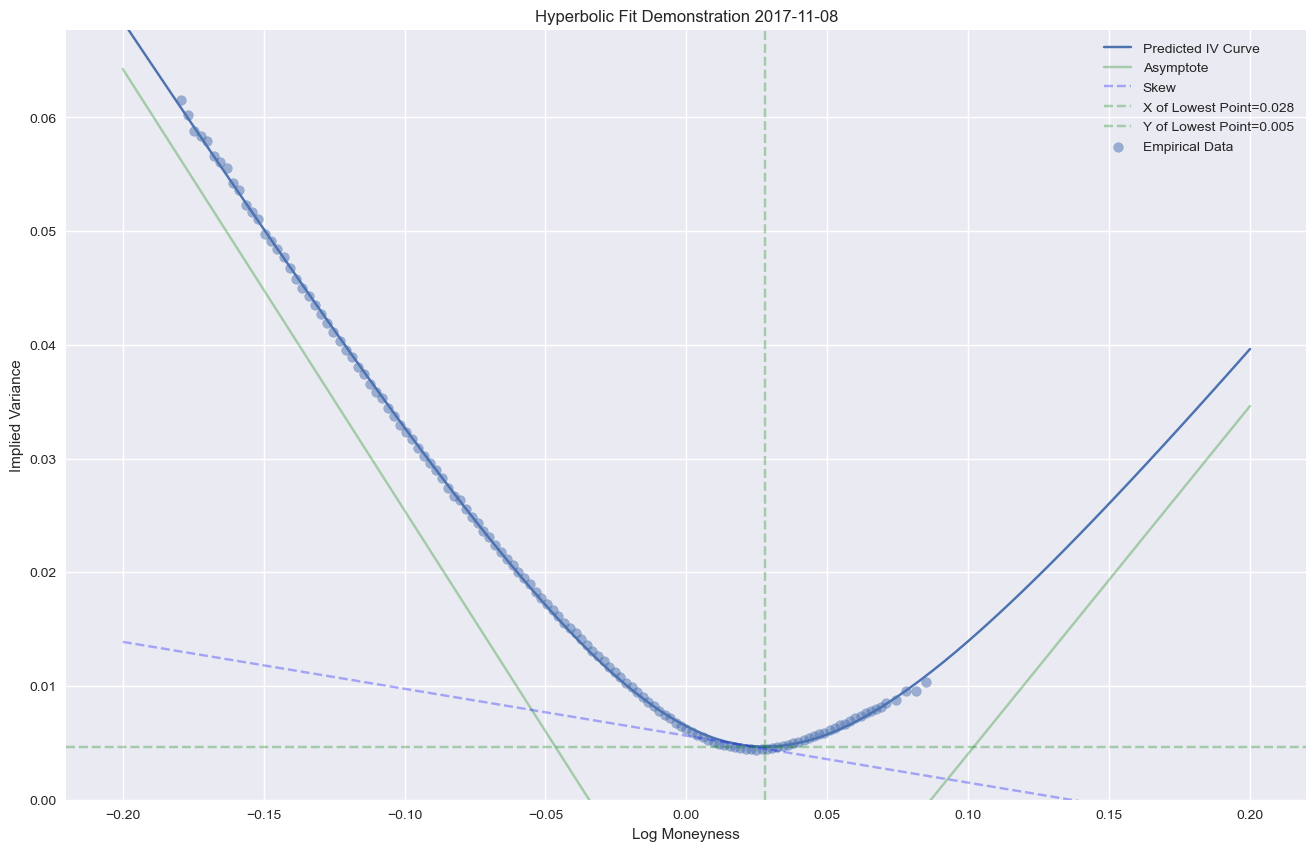

In [14]:
def visualize(ax, X, params):
    """Draws the hyperbola according to params with relevant details
    including asymptotes and minima"""
    a, b, c, d, e = params

    slpos = (b/a +d)*(X-c)+e
    slneg = (-b/a+d)*(X-c)+e
    foci  = (b**2 + a**2)**0.5 + e
    locl  = hyperbola_minimizer(a, b, c, d, e)
    lowest= hyperbola(locl, a, b, c, d, e)
    skew  = d*(X-c) + b + e

    ax.plot(X, hyperbola(X, *params), label="Predicted IV Curve")

    # ax.plot(locl, foci, "go", alpha=0.3, label="Focal Point")

    ax.plot(X, slpos, color='g', alpha=0.3, label="Asymptote")
    ax.plot(X, slneg, color='g', alpha=0.3)

    ax.plot(X, skew, color='b', alpha=0.3, linestyle="--", label="Skew")

    ax.axvline(locl, color='g', alpha=0.3, linestyle="--", 
               label=f"X of Lowest Point={locl:.3f}")
    ax.axhline(lowest, color='g', alpha=0.3, linestyle="--", 
               label=f"Y of Lowest Point={lowest:.3f}")
    
    return ax

sel = 90
to_plot = to_fit[to_fit["TS"]==tss[sel]]
params  = fit_df.loc[tss[sel]].values

fig, ax = plt.subplots()

ax = visualize(ax, X, params)

ax.scatter(to_plot["LOG_MONEYNESS_F"], to_plot["IV_MID"]**2, alpha=0.5, 
           label="Empirical Data")

# plt.ylim([(to_plot["IV_MID"].min()**2)*0.8, (to_plot["IV_MID"].max()**2)*1.1])
ax.set_ylim([0, (to_plot["IV_MID"].max()**2)*1.1])

ax.set_title(f"Hyperbolic Fit Demonstration {str(tss[sel])[:10]}")
ax.set_xlabel("Log Moneyness")
ax.set_ylabel("Implied Variance")
ax.legend()

plt.show()

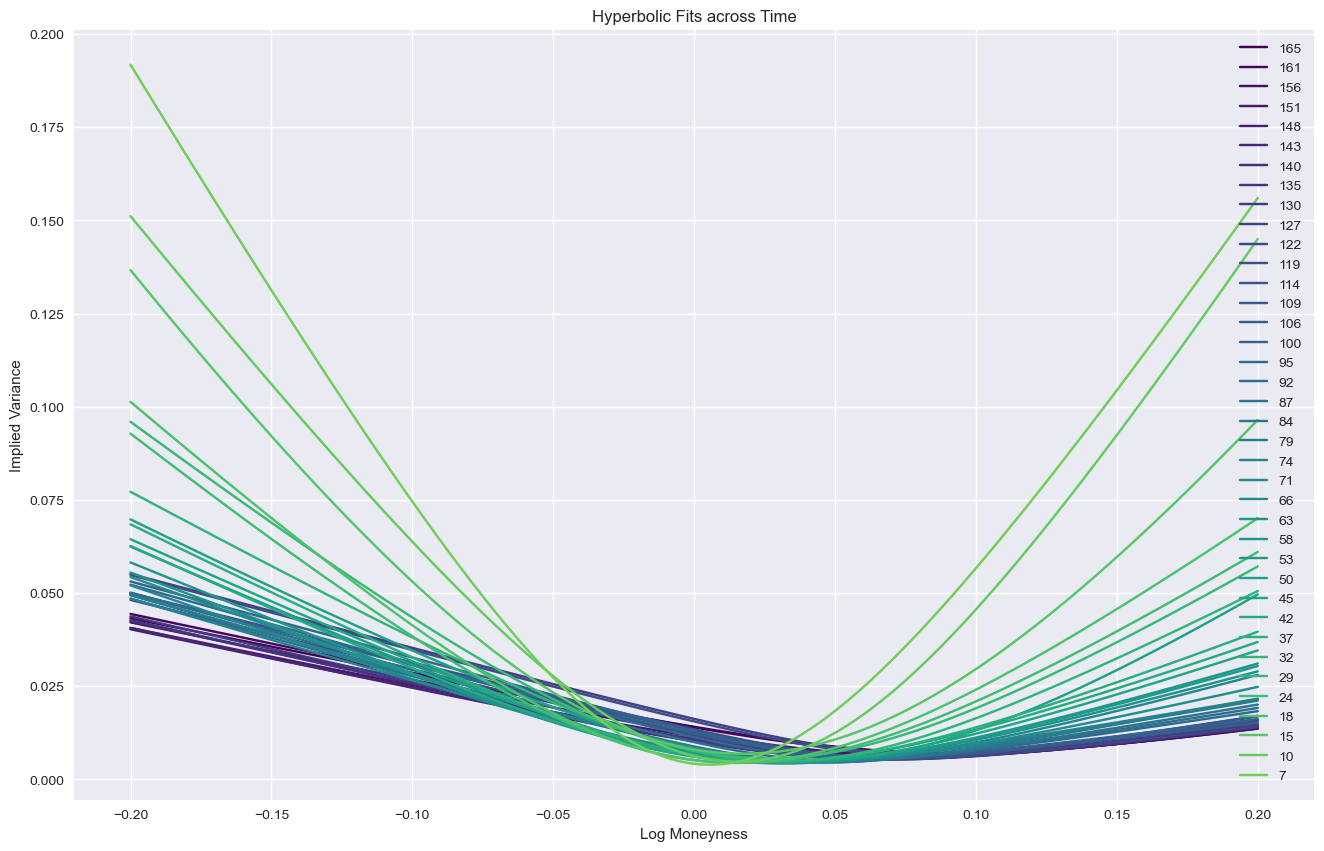

In [12]:
s = 3

# skips = preds[::s]
dte = to_fit["CAL_DAYS"].unique()#[::s]
n = len(preds) // s
colors = cm.viridis(np.linspace(0,0.8,n+1))

for i in range(n):
    plt.plot(X, preds[i*s], color=colors[i], label=dte[i*s])

plt.title("Hyperbolic Fits across Time")
plt.xlabel("Log Moneyness")
plt.ylabel("Implied Variance")
plt.legend()
plt.show()

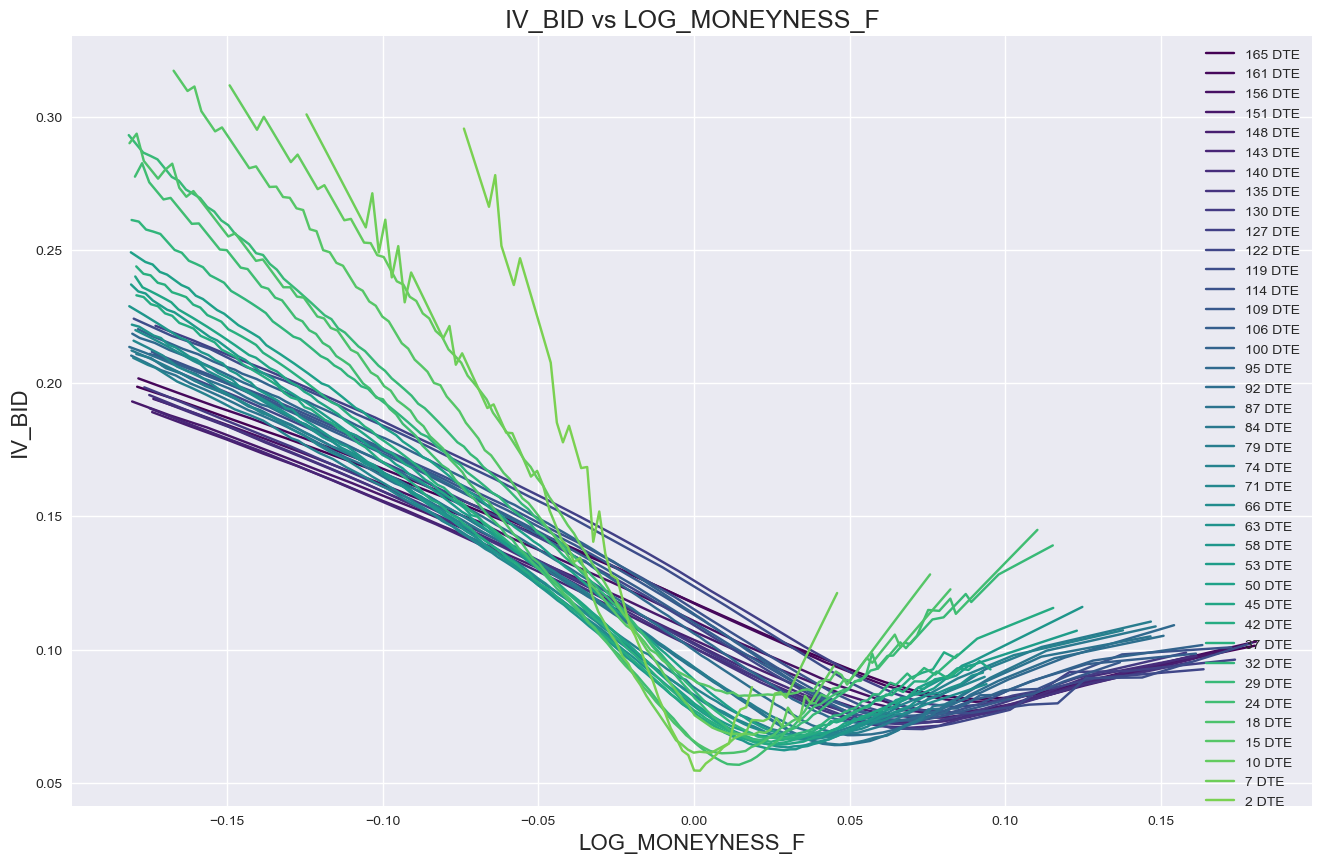

In [13]:
plot_IV_2D(df, "LOG_MONEYNESS_F", "IV_BID", interval=3)

# Parameter Stability

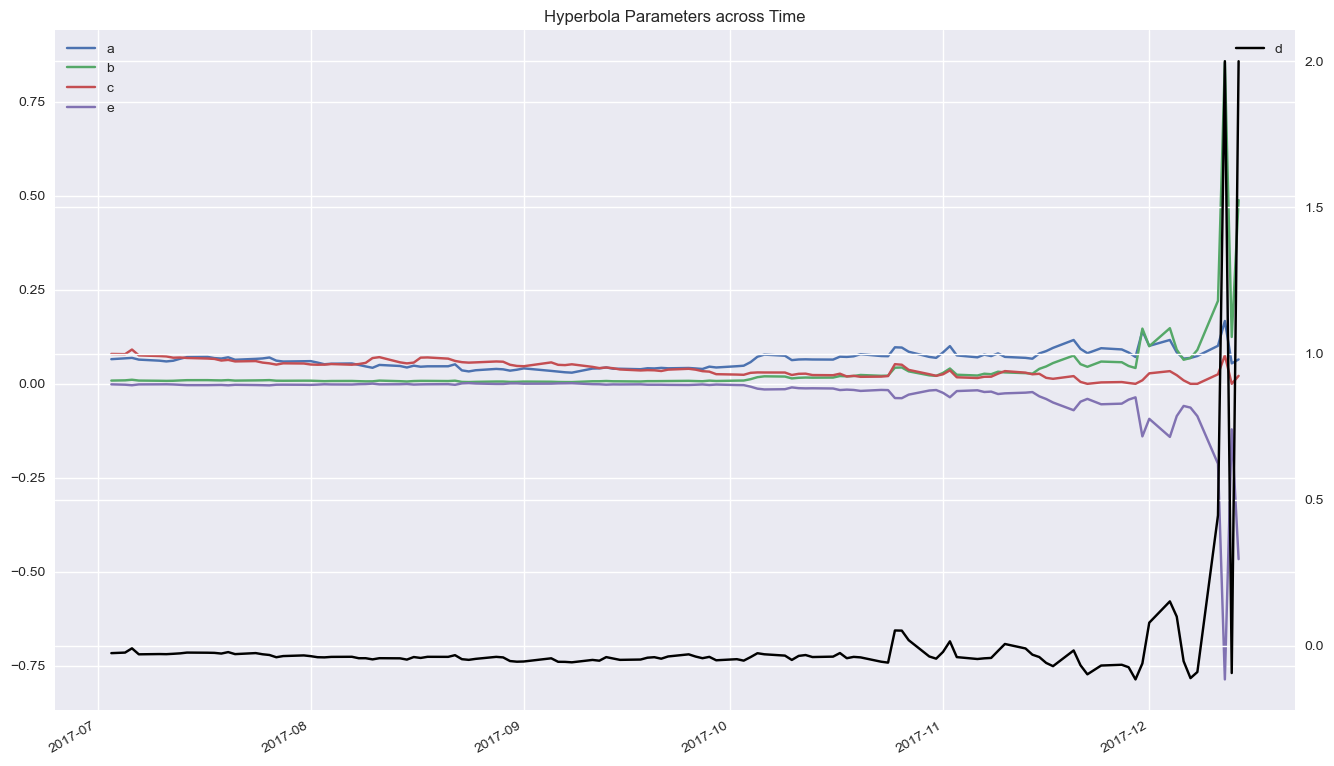

In [13]:
fig, axl = plt.subplots()
axr = axl.twinx()

fit_df[['a', 'b', 'c', 'e']].plot(ax=axl)
fit_df['d'].plot(color='k', ax=axr)
plt.title("Hyperbola Parameters across Time")
axl.legend(loc="upper left")
axr.legend(loc="upper right")
plt.show()

# Interpreting Coefficients

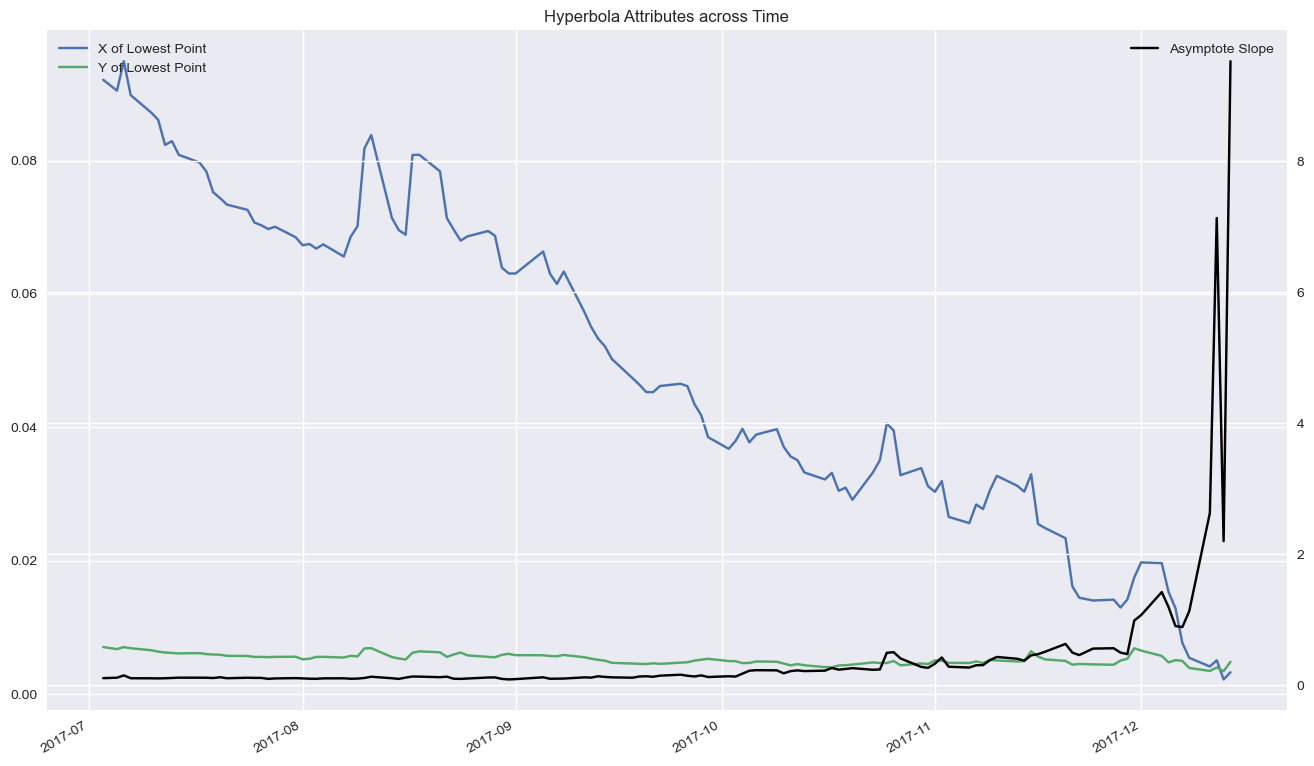

In [14]:
asymp = fit_df['b'] / fit_df['a'] + fit_df['d']
foci  = (fit_df['b']**2 + fit_df['a']**2)**0.5 + fit_df['e']
locl  = hyperbola_minimizer(fit_df['a'], fit_df['b'], fit_df['c'], fit_df['d'], fit_df['e'])
lowest= hyperbola(locl, fit_df['a'], fit_df['b'], fit_df['c'], fit_df['d'], fit_df['e'])

fig, axl = plt.subplots()
axr = axl.twinx()

asymp.plot(label="Asymptote Slope", color='k', ax=axr)
# foci.plot(label="Focal Point Height", ax=axl)
locl.plot(label="X of Lowest Point", ax=axl)
lowest.plot(label="Y of Lowest Point", ax=axl)

plt.title("Hyperbola Attributes across Time")
axl.legend(loc="upper left")
axr.legend(loc="upper right")
plt.show()